# STA414/STA2104: Assignment 2
- **Deadline**: Feb 20, at 23:59.
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# Markov chain Monte Carlo in the TrueSkill model [26 points total]

The goal of this question is to get you familiar with the basics of
Bayesian inference in medium-sized models with continuous latent variables, and the basics of Hamiltonian Monte Carlo.

## Background

We'll implement a variant of the [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess.

This assignment is based on [this one](http://mlg.eng.cam.ac.uk/teaching/4f13/1920/) developed by Carl Rasmussen at Cambridge for his course on probabilistic machine learning.

## Model definition
We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are \emph{a priori} independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import jax
import jax.numpy as np
from jax import jit, grad
from jax.ops import index_update
from jax.random import PRNGKey, normal, split, uniform
from jax.scipy.stats import norm
from jax.lax import cond, fori_loop

import scipy.io
import scipy.stats

from functools import partial

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
  # axis=-1 means sum over the last dimension.
  return np.sum(norm.logpdf(x, mu, std), axis=-1)

## Implementing the TrueSkill Model

###	Q 1.a [1 point]
Implement a function $\texttt{log_joint_prior}$ that computes the log of the prior, jointly evaluated over all player's skills.

  Specifically, given an array of the skills for all $N$ players, it returns the log-prior for that set of skills.

In [2]:
def log_joint_prior(zs_array):
  # Hint: Use diag_gaussian_log_density
  # TODO
    return diag_gaussian_log_density(zs_array, 0, 1)
    

### Q 1.b [3 points]

Implement a function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, use the function `np.log1pexp` that computes $\log(1 + \exp(x))$ in a numerically stable way.  Or even better, use `np.logaddexp`.

To test this function, we recommend checking:
 1. that it's close to zero when z_b is much larger than z_a,
 2. that it's close to one when  z_a is much larger than z_b,
 3. that it's 0.5 when z_a == z_b.


In [3]:
def logp_a_beats_b(z_a, z_b):
    
    '''
    This function computes the log-likelihood of a beats b 
    according to the likelihood described in the model 
    definition
    '''
    return -np.logaddexp(0, z_b - z_a)
    

## Q 2 Examining the posterior for only two players and toy data
To get a feel for this model, we'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games.

Provided in the starter code is a function `plot_2d_fun` which evaluates a provided function on a grid of $z_A$ and $z_B$'s and plots the isocontours of that function.
We have included an example for how you can use this functions.


In [4]:
# Plotting helper functions
def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(X.ravel(), Y.ravel())
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()
    

### Q 2.a [Free]
For two players $A$ and $B$, plot the isocontours of the joint prior over their skills.  Also plot the line of equal skill, $z_A = z_B$.  You've already implemented the log of this function, you just need to graph it using the helper function `plot_2d_fun` above.

For this and the following plots, label both axes.

To think about: According to the prior, what's the chance that player A is better than player B?

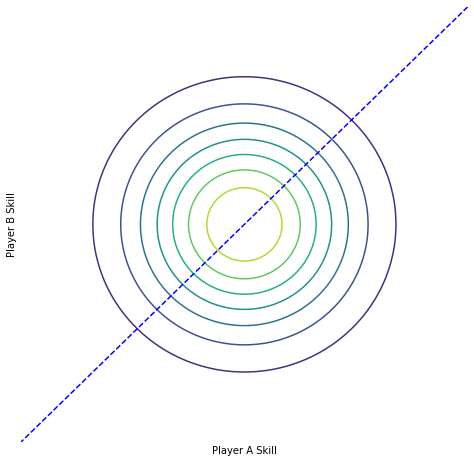

<Figure size 432x288 with 0 Axes>

In [5]:
def log_prior_over_2_players(z1, z2):
  return norm.logpdf(z1, 0.0, 1.0) + norm.logpdf(z2, 0.0, 1.0)

def prior_over_2_players(z1, z2):
  return np.exp(log_prior_over_2_players(z1, z2))

plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill")

### Q 2.b [1 point]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that player A beat player B in one match.  Since the contours don't depend on the normalization constant, you can simply plot the isocontours of the log of joint distribution of $p(z_A, z_B, \text{A beat B})$
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, which player is likely to have higher skill?

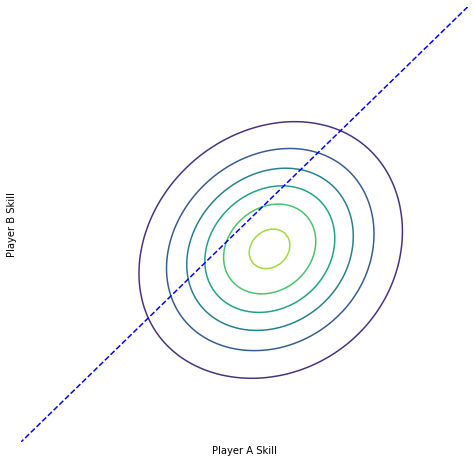

<Figure size 432x288 with 0 Axes>

In [6]:
def log_posterior_A_beat_B(z1, z2):
  # Combine the prior for two players with the likelihood for A beat B.
  # You might want to use the log_prior_over_2_players function from above.
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
  return np.exp(log_posterior_A_beat_B(z1, z2))

plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")

### Q 2.c [1 point]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
10 matches were played, and player A beat player B all 10 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it plausible that player B is more skilled than player A?

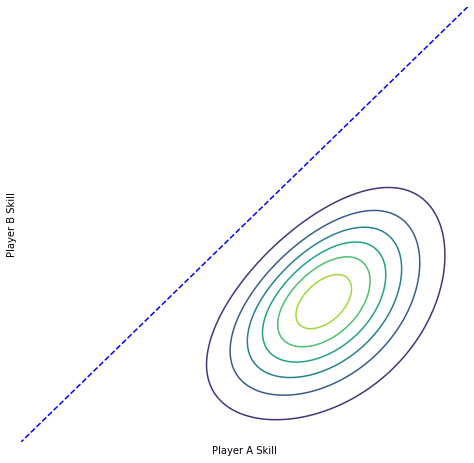

<Figure size 432x288 with 0 Axes>

In [7]:
def log_posterior_A_beat_B_10_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + 10*logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
  return np.exp(log_posterior_A_beat_B_10_times(z1, z2))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill")

### Q 2.d [1 point]

Plot isocontours of the joint posterior over $z_A$ and $z_B$ given that
20 matches were played, and each player beat the other 10 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it likely that one player is much better than another?  Is it plausible that both players are better than average?  Worse than average?

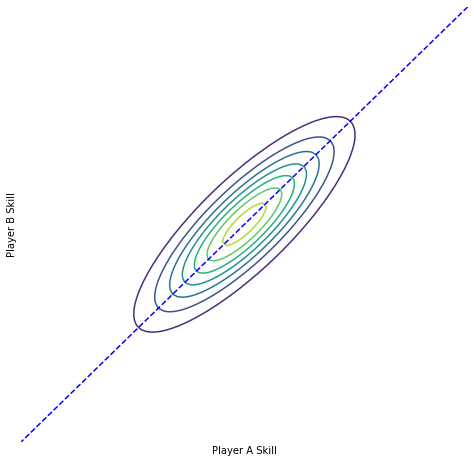

<Figure size 432x288 with 0 Axes>

In [8]:
def log_posterior_beat_each_other_10_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + 10*logp_a_beats_b(z1, z2) + 10*logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
  return np.exp(log_posterior_beat_each_other_10_times(z1, z2))
plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill")

## Q 3 Hamiltonian Monte Carlo on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.
Carl Rasmussen's assignment uses Gibbs sampling.

In this question we will  approximate posterior distributions with gradient-based Hamiltonian Monte Carlo.

In the next assignment, we'll use gradient-based stochastic variational inference, which wasn't invented until around 2014. 

### Q 3.a [2 points]

Implement the single missing line in the below code, to complete the Metropolis-Hastings accept-reject step.

In [9]:
# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  # See https://en.wikipedia.org/wiki/Leapfrog_integration
  momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
  params_t1 =      params_t0      +       stepsize * momentum_thalf
  momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
  return params_t1, momentum_t1

@partial(jit, static_argnums=(3, 4))
def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
  for i in range(0, num_leapfrog_steps):
    theta, v = leapfrog(theta, v, stepsize, grad_fun)
  return theta, v 

def metropolis_hastings(state1, state2, key, log_posterior):
  # Compares the log_posterior at two values of parameters,
  # and accepts the new values proportional to the ratio of the posterior
  # probabilities.
  accept_prob = min(1, np.exp(log_posterior(state1)-log_posterior(state2)))
    # TODO: fill in this line.
  if uniform(key) < accept_prob:
    return state2  # Accept
  else:
    return state1  # Reject


def draw_samples(num_params, stepsize, key, num_leapfrog_steps, n_samples, log_posterior):
  theta = np.zeros(num_params)

  @jit
  def log_joint_density_over_params_and_momentum(state):
    params, momentum = state
    return diag_gaussian_log_density(momentum, np.zeros_like(momentum), np.ones_like(momentum)) \
     + log_posterior(params)

  grad_fun = jit(grad(log_posterior))

  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(theta)

    key, subkey = jax.random.split(key)
    momentum = jax.random.normal(subkey, np.shape(theta))
    
    theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)
    
    key, subkey = jax.random.split(key)
    theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), subkey, log_joint_density_over_params_and_momentum)
  return np.array(sampleslist)


### Q 3.b [Free]}

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 1 game.

In [10]:
num_params = 2
theta = np.zeros(num_params)
sampleslist = []
sampleslist.append(theta)
key = jax.random.split(PRNGKey(0))
key, subkey = jax.random.split(key)
momentum = jax.random.normal(subkey, np.shape(theta))


In [11]:
momentum

DeviceArray([-0.43018502, -1.4368919 ], dtype=float32)

In [12]:
theta

DeviceArray([0., 0.], dtype=float32)

100%|██████████| 1000/1000 [00:03<00:00, 276.75it/s]


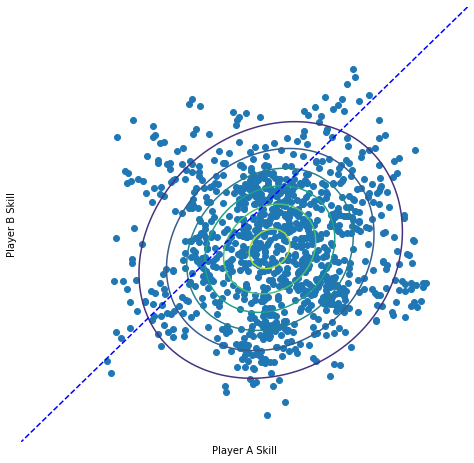

<Figure size 432x288 with 0 Axes>

In [13]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 1000
stepsize = 0.01
key = PRNGKey(0)

@jit
def log_posterior_a(zs):
  (z1, z2) = zs
  return log_posterior_A_beat_B(z1, z2)

samples_a = draw_samples(num_players, stepsize, key, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

### Q 3.c [1 point]}

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 10 games against player B.  Hint:  You can re-use the code from when you plotted the isocontours.

100%|██████████| 1000/1000 [00:03<00:00, 276.39it/s]


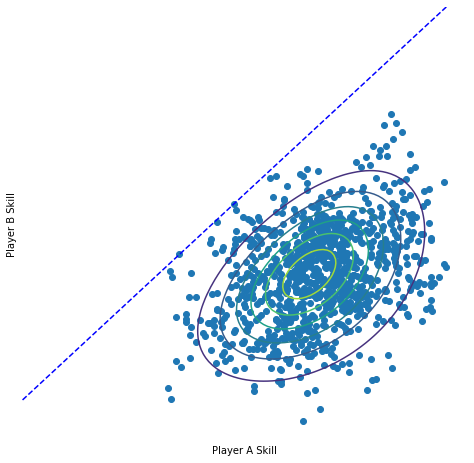

<Figure size 432x288 with 0 Axes>

In [14]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 1000
stepsize = 0.01
key = PRNGKey(0)

@jit
def log_posterior_b(zs):
  (z1, z2) = zs
  return log_posterior_A_beat_B_10_times(z1, z2)

samples_b = draw_samples(num_players, stepsize, key, num_leapfrog_steps, n_samples, log_posterior_b)
# TODO
plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill", samples_b)

### Q 3.d [1 point]}

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 10 games and player B winning 10 games.

100%|██████████| 1000/1000 [00:05<00:00, 189.64it/s]


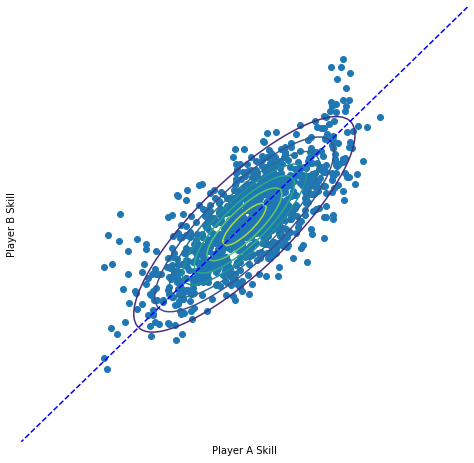

<Figure size 432x288 with 0 Axes>

In [15]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 1000
stepsize = 0.01
key = PRNGKey(0)

@jit
def log_posterior(zs):
  (z1, z2) = zs
  return log_posterior_beat_each_other_10_times(z1, z2)

samples_c = draw_samples(num_players, stepsize, key, num_leapfrog_steps, n_samples, log_posterior)
plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill", samples_c)

## Q 4 Approximate inference conditioned on real data

The dataset from $\texttt{tennis_data.mat}$ contains data on 1801 tennis games amongst 107 players:
 - W is a 107 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.





In [16]:
wget.download("https://probmlcourse.github.io/csc412/assignments/assignment_2/tennis_data.mat")
data = scipy.io.loadmat('tennis_data.mat')

games = data['G'] - 1 # A list of pairs of player numbers, representing game outcomes. (shape (1081, 2))
names = data['W']     # A list of names of players, corresponding to the player numbers. (shape (107, 1))

print(games[0,:])
print(names[0])

[0 1]
[array(['Rafael-Nadal'], dtype='<U12')]


### Q 4.a [4 points]

Assuming all game outcomes are i.i.d. conditioned on all players' skills, implement a function $\texttt{log_games_likelihood}$ that takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihoods for all those observations given all the skills.

Hint: You should be able to write this function without using $\texttt{for}$ loops, although you might want to start that way to make sure what you've written is correct.  If $A$ is an array of integers, you can index the corresponding entries of another matrix $B$ for every entry in $A$ by writing $\texttt{B[A]}$.

In [17]:
def log_games_likelihood(zs, games):
  # matches is an array of size (num_games x 2)
  # zs is an array of size (num_samples x num_players)
  # returns a scalar
  #
  # Hint: With broadcasting, this function can be written
  # with no for loops.
  #
  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]
  winning_player_skills = zs[winning_player_ixs]    #TODO: Look up the skill of the winning player in each game.
  losing_player_skills = zs[losing_player_ixs]      #TODO: Look up the skills of the losing player in each game.
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)          #TODO: Compute the log_likelihood of each game outcome.
  return np.sum(log_likelihoods)                 #TODO: Combine the log_likelihood of independent events.


  
## Q 4.a2 [2 points]
Implement a function $\texttt{joint_log_density}$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [18]:
def log_joint_probability(zs, games):
  # Todo: Combine log_prior and log_likelihood.
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

### Q 4.b [1 point]
Run Hamiltonian Monte Carlo on the posterior over all skills conditioned on all the tennis games from the dataset.  Run for at least 1000 samples.

Something to think about:  Why aren't we plotting the 2d marginal density here?  What makes that difficult?

In [19]:
# Hyperparameters
num_players = 107
num_leapfrog_steps = 20
n_samples = 1000
stepsize = 0.01
key = PRNGKey(0)

@jit
def log_unnormalized_posterior(zs):
  return log_joint_probability(zs, games)
# TODO what function do you have that's proportoinal to the posterior?

all_games_samples = draw_samples(num_players, stepsize, key, num_leapfrog_steps, n_samples, log_unnormalized_posterior)
# Nothing necessary to plot in this question.

100%|██████████| 1000/1000 [00:08<00:00, 120.34it/s]


### Q 4.c [2 points]
Based on your samples from the previous question, plot the approximate mean and variance of the marginal skill of each player, sorted by average skill. There's no need to include the names of the players.  Label the axes "Player Rank", and "Player Skill".

<ErrorbarContainer object of 3 artists>

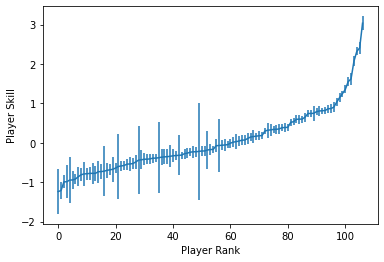

In [20]:
mean_skills = np.mean(all_games_samples, axis=0)# TODO: A function of all_games_samples
var_skills =  np.var(all_games_samples, axis=0)# TODO: A function of all_games_samples

order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(107), mean_skills[order], var_skills[order])

The rank of a player is usually asigned from best to worst, so with a small correction to the code above we have

<ErrorbarContainer object of 3 artists>

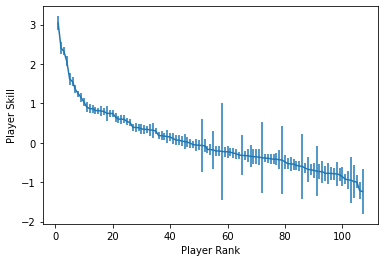

In [21]:
mean_skills = np.mean(all_games_samples, axis=0)# TODO: A function of all_games_samples
var_skills =  np.var(all_games_samples, axis=0)# TODO: A function of all_games_samples

order_desc = np.argsort(mean_skills)[::-1]

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(1,108), mean_skills[order_desc], var_skills[order_desc])

### Q 4.d [1 point]
List the names of the 10 players with the highest mean skill according to your samples.  Hint: you can re-use `order` from the previous question.  It's OK if, due to randomness, you get a slightly different order than others.

In [22]:
for i in range(1,11):
  print(*names[order][-i])

['Novak-Djokovic']
['Roger-Federer']
['Rafael-Nadal']
['Andy-Murray']
['Robin-Soderling']
['David-Ferrer']
['Jo-Wilfried-Tsonga']
['Tomas-Berdych']
['Juan-Martin-Del-Potro']
['Richard-Gasquet']


### Q 4.e [1 point]
Use a scatterplot to show your samples over the joint posterior over the skills of Roger Federer and Rafael Nadal.  Include the line of equal skill.  Hint: you can use `plt.scatter`.


[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Roger-Federer'], dtype='<U13')]


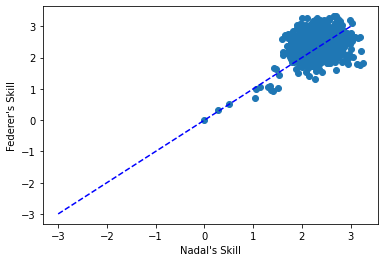

In [23]:
nadal_ix = 0
federer_ix = 4
print(names[nadal_ix])
print(names[federer_ix])

plt.xlabel("Nadal's Skill")
plt.ylabel("Federer's Skill")
plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
plt.scatter(x=all_games_samples[:,nadal_ix], y=all_games_samples[:,federer_ix])

#### Scatterplot for any two players (out of curiosity)

In [24]:
import pandas as pd
names_df = pd.DataFrame({'names': [name[0][0] for name in names]})

In [25]:
def get_tennis_player_index(names_df, name):
    
    '''
    Get index of tennis player according to the names_df
    '''
    
    return names_df.index[names_df['names']==name][0]

def tennis_players_skills(player_x, player_y, names_df):
    
    '''
    Graph scatter plot of skill of two tennis players
    '''
    
    player_x_ix = get_tennis_player_index(names_df, player_x)
    player_y_ix = get_tennis_player_index(names_df, player_y)

    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.scatter(x=all_games_samples[:,player_x_ix], y=all_games_samples[:,player_y_ix])
    
    plt.xlabel(f"{player_x.replace('-',' ')}s Skill")
    plt.ylabel(f"{player_y.replace('-',' ')}'s Skill")


Now, we can create the scatter plot of any to players, for example:

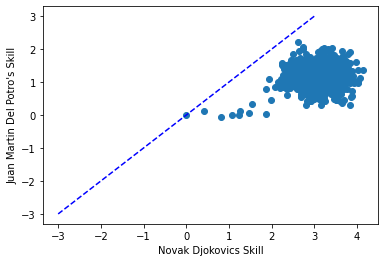

In [26]:
tennis_players_skills('Novak-Djokovic', 'Juan-Martin-Del-Potro', names_df)

### Q 4.f [2 points]
Using your samples, print an unbiased estimate of the probability that Roger Federer is better than Rafael Nadal, as estimated from your samples.  Hint: Probabilities of Bernoulli random variables can be written as the expectation that the Bernoulli takes value 1, so you can use simple Monte Carlo.  The final formula will be very simple.

In [27]:
prob_federer_better_than_nadal = np.sum(all_games_samples[:, federer_ix] > all_games_samples[:, nadal_ix])/n_samples
print(prob_federer_better_than_nadal)

0.586


### Q 4.g [1 point]
Using your samples, find the player that has the lowest mean skill. Print an unbiased estimate of the probability that Roger Federer is better than that player, again as estimated from your samples.  Hint: Probabilities of Bernoulli random variables can be written as the expectation that the Bernoulli takes value 1, so you can use simple Monte Carlo.  The final formula will be very simple.

In [28]:
worst_player_ix = order[0]
worst_player_name = names_df.iloc[int(worst_player_ix), 0]
prob_federer_better_than_worst_player = np.sum(all_games_samples[:, federer_ix] > all_games_samples[:, worst_player_ix])/n_samples
print(prob_federer_better_than_worst_player)

0.999


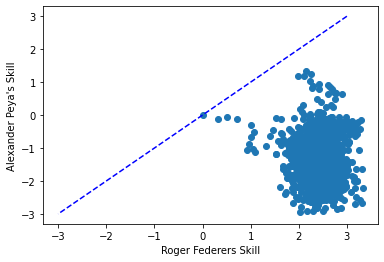

In [29]:
tennis_players_skills('Roger-Federer', worst_player_name, names_df)

### Q 4.h [1 point]

For any two players $i$ and $j$, $p(z_i, z_j | \text{all games})$ is always proportional to $p(z_i, z_j , \text{all games})$, as a function of $z_i$ and $z_j$.

In general, are the isocontours of $p(z_i, z_j | \text{all games})$ the same as those of $p(z_i, z_j | \text{games between $i$ and $j$})$?  That is, do the games between other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$?  A simple yes or no suffices.

Hint: One way to answer this is to draw the graphical model for three players, $i$, $j$, and $k$, and the results of games between all three pairs, and then examine conditional independencies.  If you do this, there's no need to include the graphical models in your assignment.

Your answer here:  Yes or no? No